## Imports and Installations

In [16]:
!pip install -q segmentation-models-pytorch timm ultralytics effdet

In [1]:
import os, glob, random, time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
from ultralytics import YOLO

import tensorflow as tf
from tensorflow.keras.models import load_model
from effdet import create_model

## Paths to Folders

In [2]:
# Root folders
SEG_ROOT = r"C:\Users\ksaks\Documents\Masters Stuff\DL\EuroPalletSeg"   # train/valid/images, train/valid/masks
DET_ROOT = r"C:\Users\ksaks\Documents\Masters Stuff\DL\EuroPalletSeg"              # train/valid/test/images + labels

# Model checkpoints
UNET_H5     = r"C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\best_model_epoch52_valacc0.99.h5"
DEEPLAB_PTH = r"C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\deeplabv3p_mnv_best.pth"

YOLO_PT     = r"C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\best_epoch87_mAP0.833.pt"
EFFDET_PTH  = r"C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\effdet_d0_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Helper Functions

In [3]:
def compute_iou_np(y_pred, y_true, eps=1e-6):
    """
    y_pred, y_true: (N,H,W) or (N,H,W,1) with 0/1 values
    """
    y_pred = y_pred.astype(np.float32).reshape(y_pred.shape[0], -1)
    y_true = y_true.astype(np.float32).reshape(y_true.shape[0], -1)
    inter = (y_pred * y_true).sum(axis=1)
    union = y_pred.sum(axis=1) + y_true.sum(axis=1) - inter
    return ((inter + eps) / (union + eps)).mean()

def compute_dice_np(y_pred, y_true, eps=1e-6):
    y_pred = y_pred.astype(np.float32).reshape(y_pred.shape[0], -1)
    y_true = y_true.astype(np.float32).reshape(y_true.shape[0], -1)
    inter = (y_pred * y_true).sum(axis=1)
    return ((2 * inter + eps) / (y_pred.sum(axis=1) + y_true.sum(axis=1) + eps)).mean()

## Segmentation

### Segmentation Validation Set

In [4]:
IMG_SIZE = 256  # common size for U-Net and DeepLabV3+

val_img_paths = sorted(
    glob.glob(f"{SEG_ROOT}/valid/images/*.jpg") +
    glob.glob(f"{SEG_ROOT}/valid/images/*.jpeg") +
    glob.glob(f"{SEG_ROOT}/valid/images/*.png")
)
val_mask_paths = sorted(
    glob.glob(f"{SEG_ROOT}/valid/masks/*.png") +
    glob.glob(f"{SEG_ROOT}/valid/masks/*.jpg") +
    glob.glob(f"{SEG_ROOT}/valid/masks/*.jpeg")
)

assert len(val_img_paths) == len(val_mask_paths) and len(val_img_paths) > 0, "Check SEG_ROOT/valid paths."

def load_segmentation_val(img_paths, mask_paths, img_size=IMG_SIZE):
    imgs, masks = [], []
    for ip, mp in zip(img_paths, mask_paths):
        img = cv2.cvtColor(cv2.imread(ip), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.float32)  # 0/1

        imgs.append(img)
        masks.append(mask)
    return np.stack(imgs), np.stack(masks), img_paths, mask_paths

seg_imgs, seg_masks, seg_img_paths, seg_mask_paths = load_segmentation_val(val_img_paths, val_mask_paths)
print("Segmentation val shapes:", seg_imgs.shape, seg_masks.shape)

Segmentation val shapes: (585, 256, 256, 3) (585, 256, 256)


### Segmentation Models

In [5]:
# --- U-Net baseline (TF / Keras) ---
unet_model = load_model(UNET_H5, compile=False)
print("Loaded U-Net from", UNET_H5)

# --- DeepLabV3+ MobileNetV3 variant (PyTorch) ---
deeplab_model = smp.DeepLabV3Plus(
    encoder_name="timm-mobilenetv3_large_100",
    encoder_weights=None,    # using our own trained weights
    in_channels=3,
    classes=1
)

state = torch.load(DEEPLAB_PTH, map_location="cpu")
if isinstance(state, dict) and "model_state_dict" in state:
    deeplab_model.load_state_dict(state["model_state_dict"])
else:
    deeplab_model.load_state_dict(state)

deeplab_model.to(device).eval()
print("Loaded DeepLabV3+ from", DEEPLAB_PTH)

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

Loaded U-Net from C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\best_model_epoch52_valacc0.99.h5
Loaded DeepLabV3+ from C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\deeplabv3p_mnv_best.pth


### Segmentation Inference

In [6]:
# Ground truth for metrics
y_true = seg_masks[..., None]  # (N,H,W,1)

# --- U-Net predictions ---
x_unet = seg_imgs.astype(np.float32) / 255.0
unet_pred = unet_model.predict(x_unet, batch_size=4, verbose=1)   # (N,H,W,1)
unet_bin  = (unet_pred > 0.5).astype(np.float32)

unet_iou  = compute_iou_np(unet_bin, y_true)
unet_dice = compute_dice_np(unet_bin, y_true)
print(f"U-Net baseline:   IoU = {unet_iou:.4f}, Dice = {unet_dice:.4f}")

# --- DeepLabV3+ predictions ---
x_dl = seg_imgs.astype(np.float32) / 255.0
x_dl = (x_dl - mean) / std
x_dl_t = torch.from_numpy(x_dl).permute(0, 3, 1, 2).to(device)  # (N,3,H,W)

with torch.no_grad():
    logits_list = []
    bs = 4
    for i in range(0, x_dl_t.shape[0], bs):
        out = deeplab_model(x_dl_t[i:i+bs])
        logits_list.append(out.cpu())
    logits = torch.cat(logits_list, dim=0)

deeplab_prob = torch.sigmoid(logits).numpy()        # (N,1,H,W)
deeplab_prob = np.transpose(deeplab_prob, (0, 2, 3, 1))
deeplab_bin  = (deeplab_prob > 0.5).astype(np.float32)

deeplab_iou  = compute_iou_np(deeplab_bin, y_true)
deeplab_dice = compute_dice_np(deeplab_bin, y_true)
print(f"DeepLabV3+ variant: IoU = {deeplab_iou:.4f}, Dice = {deeplab_dice:.4f}")

147/147 ━━━━━━━━━━━━━━━━━━━━ 54s 333ms/step
U-Net baseline:   IoU = 0.9510, Dice = 0.9734
DeepLabV3+ variant: IoU = 0.9216, Dice = 0.9562


### Visualizations

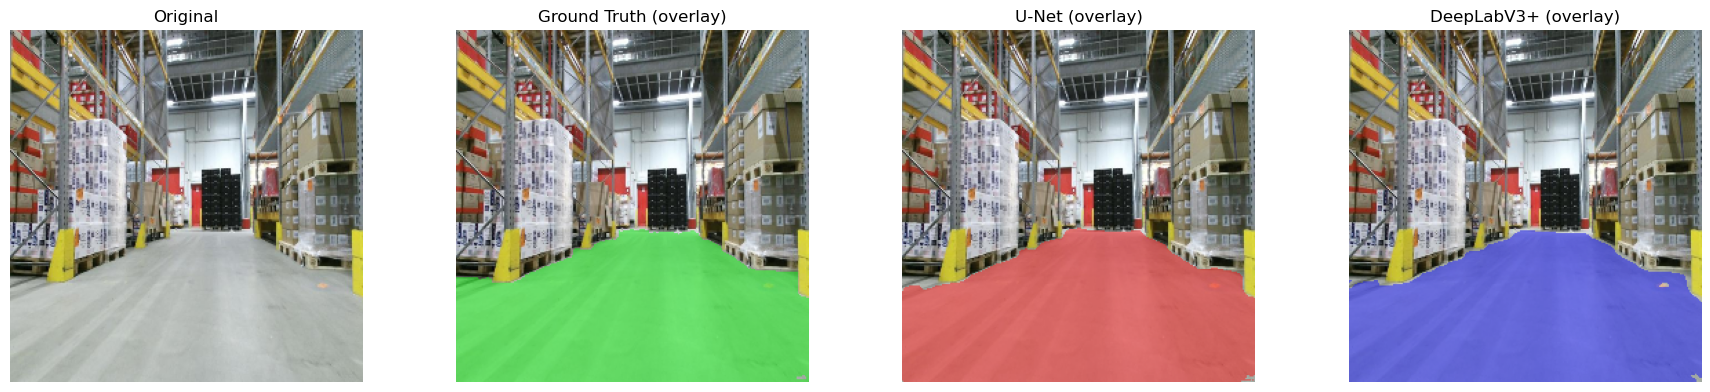

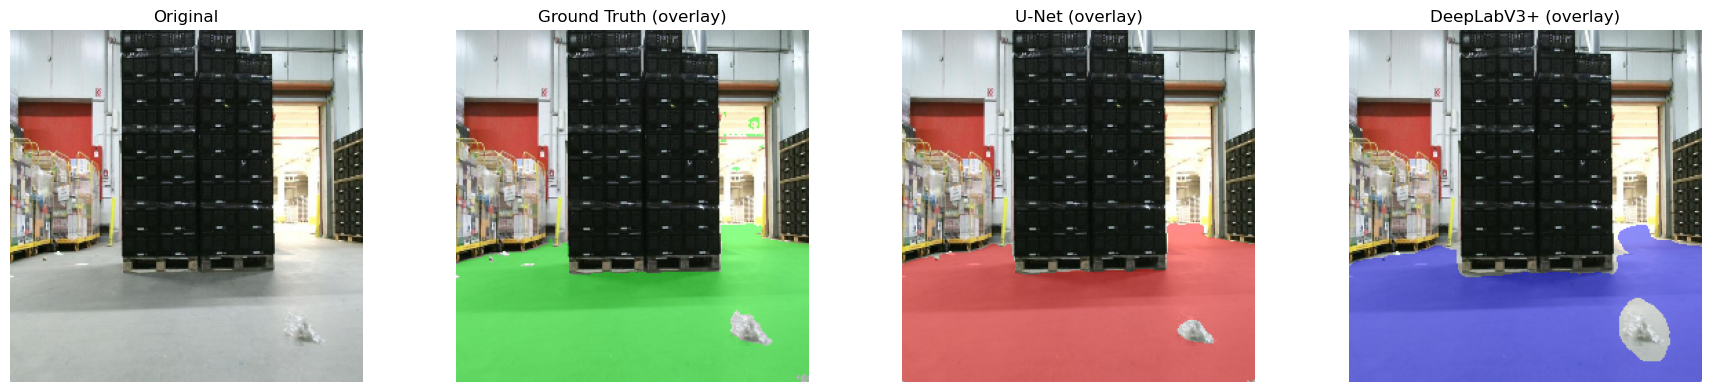

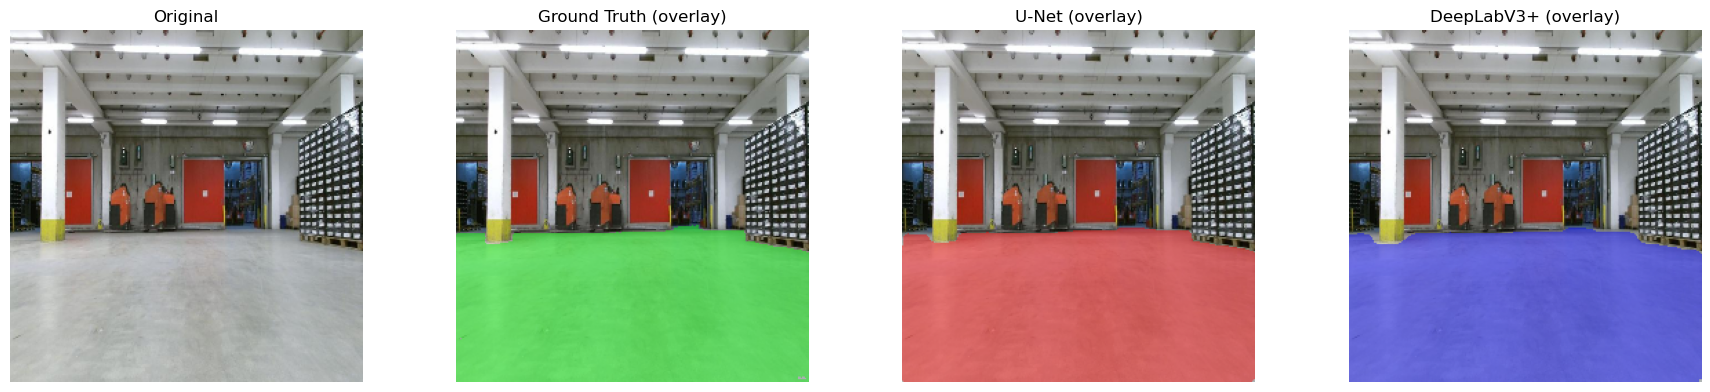

In [7]:
def apply_overlay(img, mask, color=(0, 255, 0), alpha=0.4):
    """
    img  : (H,W,3) uint8 RGB
    mask : (H,W) or (H,W,1) binary 0/1
    color: BGR or RGB tuple (we'll treat as RGB here)
    alpha: overlay opacity
    """
    base = img.copy().astype(np.float32)
    if mask.ndim == 3:
        mask = mask[..., 0]
    mask_bool = mask.astype(bool)

    color_arr = np.zeros_like(base)
    color_arr[..., 0] = color[0]
    color_arr[..., 1] = color[1]
    color_arr[..., 2] = color[2]

    # Blend only where mask is True
    base[mask_bool] = (
        alpha * color_arr[mask_bool] +
        (1.0 - alpha) * base[mask_bool]
    )

    return base.astype(np.uint8)

def show_segmentation_overlay(idx):
    img = seg_imgs[idx]                    # (H,W,3) RGB
    gt  = seg_masks[idx]                   # (H,W)
    unet_mask = unet_bin[idx, ..., 0]      # (H,W)
    dl_mask   = deeplab_bin[idx, ..., 0]   # (H,W)

    # Overlays in different colors
    gt_overlay    = apply_overlay(img, gt,         color=(0, 255, 0), alpha=0.45)   # green
    unet_overlay  = apply_overlay(img, unet_mask,  color=(255, 0, 0), alpha=0.45)   # red
    dl_overlay    = apply_overlay(img, dl_mask,    color=(0, 0, 255), alpha=0.45)   # blue

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    axes[0].imshow(img)
    axes[0].set_title("Original")

    axes[1].imshow(gt_overlay)
    axes[1].set_title("Ground Truth (overlay)")

    axes[2].imshow(unet_overlay)
    axes[2].set_title("U-Net (overlay)")

    axes[3].imshow(dl_overlay)
    axes[3].set_title("DeepLabV3+ (overlay)")

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

for i in [0, 1, 2]:
    show_segmentation_overlay(i)


## Object Detection

### Detection Helpers

In [8]:
# --- Detection val set ---

def det_valid_images(det_root):
    imgs = sorted(glob.glob(f"{det_root}/valid/images/*"))
    print(f"[det] valid images = {len(imgs)}")
    return imgs

det_val_imgs = det_valid_images(DET_ROOT)

def load_yolo_labels(txt_path, w, h):
    """
    Reads YOLO txt (cls cx cy w h normalized) and returns boxes in xyxy (pixel) form.
    Single-class for pallets.
    """
    boxes = []
    if not os.path.exists(txt_path):
        return np.zeros((0, 4), np.float32)
    with open(txt_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(float(parts[0]))
            cx, cy, bw, bh = map(float, parts[1:5])
            x1 = (cx - bw / 2) * w
            y1 = (cy - bh / 2) * h
            x2 = (cx + bw / 2) * w
            y2 = (cy + bh / 2) * h
            boxes.append([x1, y1, x2, y2])
    return np.array(boxes, np.float32)

def box_iou_np(a, b):
    # a: [N,4], b: [M,4]
    if a.size == 0 or b.size == 0:
        return np.zeros((len(a), len(b)), np.float32)
    ax1, ay1, ax2, ay2 = a[:,0], a[:,1], a[:,2], a[:,3]
    bx1, by1, bx2, by2 = b[:,0], b[:,1], b[:,2], b[:,3]
    inter_x1 = np.maximum(ax1[:, None], bx1[None])
    inter_y1 = np.maximum(ay1[:, None], by1[None])
    inter_x2 = np.minimum(ax2[:, None], bx2[None])
    inter_y2 = np.minimum(ay2[:, None], by2[None])
    inter_w = np.maximum(0.0, inter_x2 - inter_x1)
    inter_h = np.maximum(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h
    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    union = area_a[:, None] + area_b[None] - inter
    return inter / np.clip(union, 1e-6, None)

def ap_at_05(preds, gts):
    """
    preds: list of [N_i,5] arrays per image [x1,y1,x2,y2,score]
    gts:   list of [M_i,4] arrays per image [x1,y1,x2,y2]
    """
    all_scores, all_matches = [], []
    total_gts = 0

    for p, g in zip(preds, gts):
        total_gts += len(g)
        if len(p) == 0:
            continue
        ious = box_iou_np(p[:, :4], g)
        max_iou_idx = ious.argmax(axis=1) if g.size else np.zeros((len(p),), np.int64)
        max_iou = ious[np.arange(len(p)), max_iou_idx] if g.size else np.zeros((len(p),), np.float32)
        matched_gt = set()
        matches = []
        order = np.argsort(-p[:, 4])  # sort by score desc
        for i in order:
            if g.size == 0:
                matches.append(0)
                continue
            gt_j = max_iou_idx[i]
            if max_iou[i] >= 0.5 and gt_j not in matched_gt:
                matched_gt.add(gt_j)
                matches.append(1)
            else:
                matches.append(0)
            all_scores.append(p[i, 4])
        all_matches.extend(matches)

    if len(all_matches) == 0:
        return 0.0

    order = np.argsort(-np.array(all_scores))
    tp = np.cumsum(np.array(all_matches)[order])
    fp = np.cumsum(1 - np.array(all_matches)[order])
    recall = tp / max(1, total_gts)
    precision = tp / np.maximum(1, tp + fp)

    ap = 0.0
    for r in np.linspace(0, 1, 11):
        prec_at_r = precision[recall >= r].max() if np.any(recall >= r) else 0.0
        ap += prec_at_r
    ap /= 11.0
    return float(ap)

def eval_detector(predict_fn, imgs, conf=0.25):
    preds, gts = [], []
    t0 = time.perf_counter()
    for ip in imgs:
        det = predict_fn(ip, conf=conf)
        preds.append(det)
        img = cv2.imread(ip)
        h, w = img.shape[:2]
        lp = ip.replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
        gts.append(load_yolo_labels(lp, w, h))
    dt = time.perf_counter() - t0
    return {
        "mAP@0.5": ap_at_05(preds, gts),
        "Latency_ms": (dt / len(imgs)) * 1000.0,
        "FPS": float(len(imgs) / dt)
    }

[det] valid images = 585


### Loading models

In [9]:
IMG_DET = 512
NUM_CLASSES = 1

yolo_model = YOLO(YOLO_PT)
print("Loaded YOLOv8 from", YOLO_PT)

from effdet import create_model

def build_effdet_d0():
    model = create_model(
        'tf_efficientdet_d0',
        bench_task='predict',
        num_classes=NUM_CLASSES,
        image_size=(IMG_DET, IMG_DET),
        pretrained=False
    )
    return model

det_model = build_effdet_d0()
state = torch.load(EFFDET_PTH, map_location="cpu")
if isinstance(state, dict) and "model_state_dict" in state:
    det_model.load_state_dict(state["model_state_dict"], strict=False)
else:
    det_model.load_state_dict(state, strict=False)

det_model.to(device).eval()
print("Loaded EfficientDet-D0 from", EFFDET_PTH)

Loaded YOLOv8 from C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\best_epoch87_mAP0.833.pt


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loaded EfficientDet-D0 from C:\Users\ksaks\Documents\Masters Stuff\DL\Code\Models\effdet_d0_best.pth


### Detection Inference

In [10]:
def det_predict_effdet(ip, conf=None, top_k=5):
    """
    Run EfficientDet-D0 on a single image path and return [N,5]:
    x1, y1, x2, y2, score  (in original image coords).

    - `conf` is accepted so eval_detector(predict_fn, imgs, conf=...)
      still works, but we mostly ignore it because scores are tiny.
    - We keep only the top_k highest-score boxes to avoid drawing
      all 100 anchors on the image.
    """
    bgr = cv2.imread(ip)
    h0, w0 = bgr.shape[:2]

    # Resize to model input size
    rgb = cv2.cvtColor(cv2.resize(bgr, (IMG_DET, IMG_DET)), cv2.COLOR_BGR2RGB)

    x = torch.from_numpy(
        (rgb.astype(np.float32) / 255.0).transpose(2, 0, 1)
    )[None].to(device)

    with torch.no_grad():
        out_raw = det_model(x)      # expected [1, 100, 6]

    # Normalize to [num_dets, 6]
    if isinstance(out_raw, torch.Tensor):
        out = out_raw[0].cpu().numpy()
    elif isinstance(out_raw, (list, tuple)):
        tmp = out_raw[0]
        out = tmp.cpu().numpy() if isinstance(tmp, torch.Tensor) else tmp
    elif isinstance(out_raw, dict) and "detections" in out_raw:
        tmp = out_raw["detections"]
        out = tmp[0].cpu().numpy() if isinstance(tmp, torch.Tensor) else tmp[0]
    else:
        return np.zeros((0, 5), np.float32)

    if out.ndim != 2 or out.shape[1] < 5:
        return np.zeros((0, 5), np.float32)

    # out: [num_dets, 6] => [x1, y1, x2, y2, score, cls]
    scores = out[:, 4]

    # Sort by score and keep only top_k (scores are all ~1e-4 anyway)
    order = np.argsort(scores)[::-1]
    k = min(top_k, len(order))
    out = out[order[:k]]

    # Filter out obviously invalid boxes (zero or negative area)
    valid = (out[:, 2] > out[:, 0] + 1) & (out[:, 3] > out[:, 1] + 1)
    out = out[valid]
    if out.shape[0] == 0:
        return np.zeros((0, 5), np.float32)

    # Rescale from model coords (0..IMG_DET) to original image size
    out[:, [0, 2]] *= w0 / IMG_DET
    out[:, [1, 3]] *= h0 / IMG_DET

    return out[:, :5].astype(np.float32)   # [N,5] x1,y1,x2,y2,score


def det_predict_yolo(ip, conf=0.25):
    """
    Uses YOLOv8 .pt to return [N,5]: x1,y1,x2,y2,score
    """
    bgr = cv2.imread(ip)
    results = yolo_model.predict(source=bgr, imgsz=IMG_DET, conf=conf, verbose=False)
    r = results[0]
    if r.boxes is None or len(r.boxes) == 0:
        return np.zeros((0, 5), np.float32)
    xyxy = r.boxes.xyxy.cpu().numpy()
    scores = r.boxes.conf.cpu().numpy()
    return np.concatenate([xyxy, scores[:, None]], axis=1).astype(np.float32)

det_effdet_metrics = eval_detector(det_predict_effdet, det_val_imgs, conf=0.25)
det_yolo_metrics   = eval_detector(det_predict_yolo,   det_val_imgs, conf=0.25)

print("EfficientDet-D0 variant:", det_effdet_metrics)
print("YOLOv8 baseline:",        det_yolo_metrics)

EfficientDet-D0 variant: {'mAP@0.5': 0.0, 'Latency_ms': 158.5567511112676, 'FPS': 6.306890075580872}
YOLOv8 baseline: {'mAP@0.5': 0.0, 'Latency_ms': 95.44899094010043, 'FPS': 10.476800122775062}


### Visualization

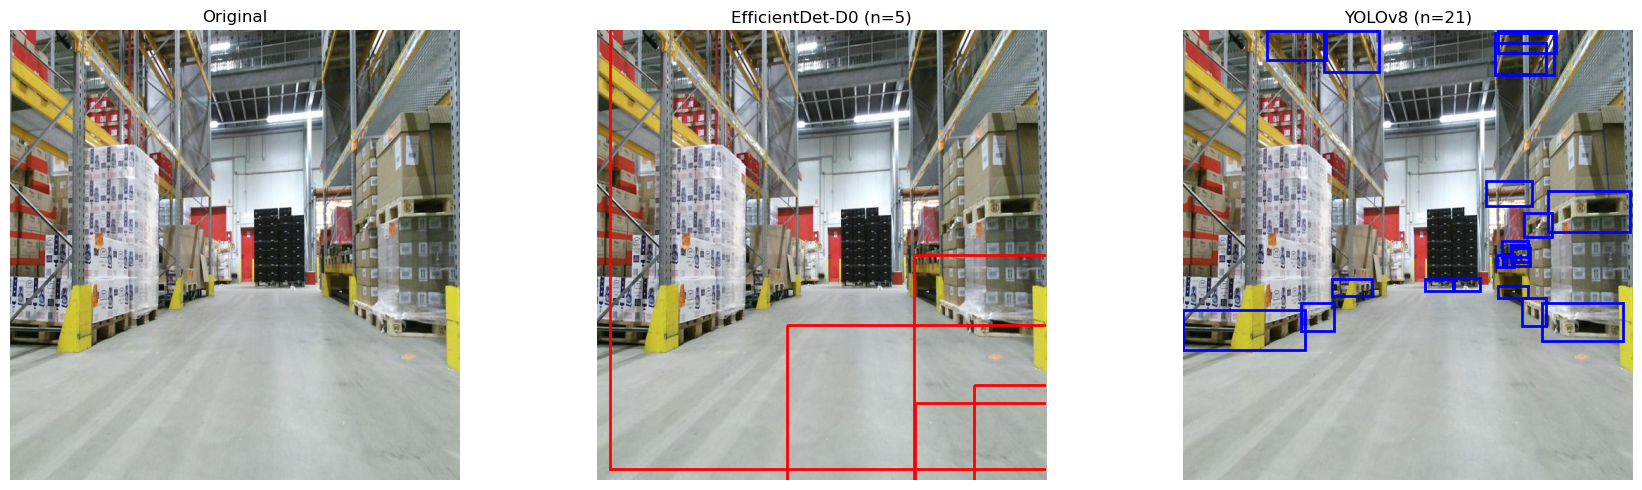

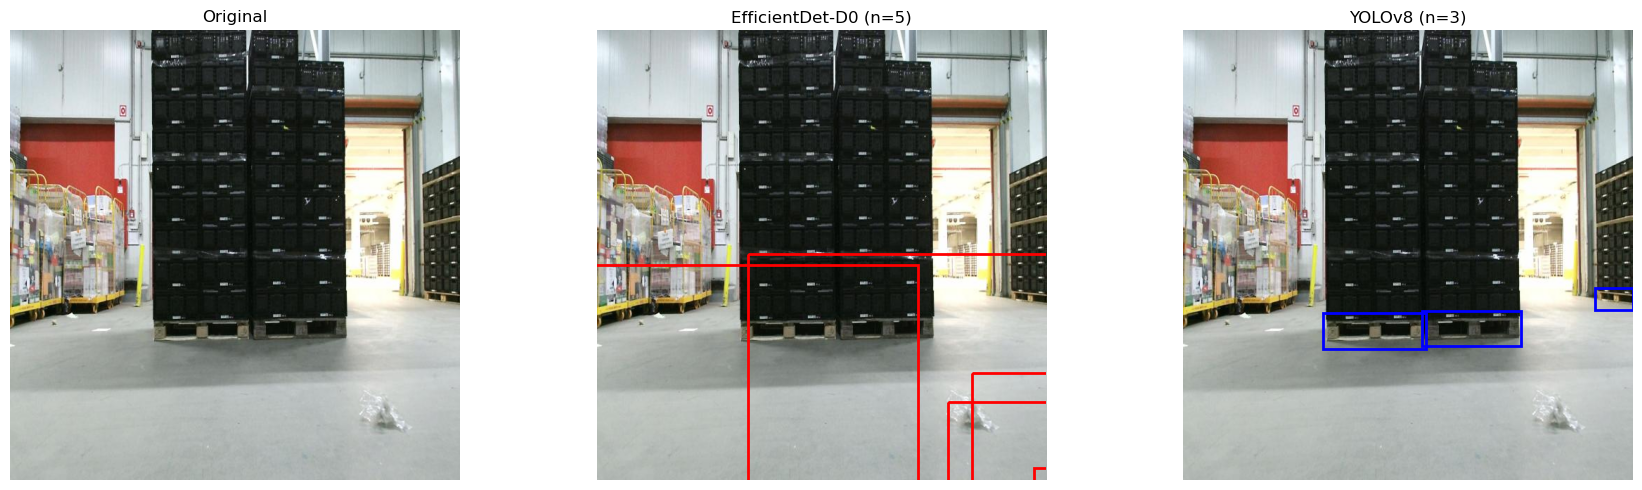

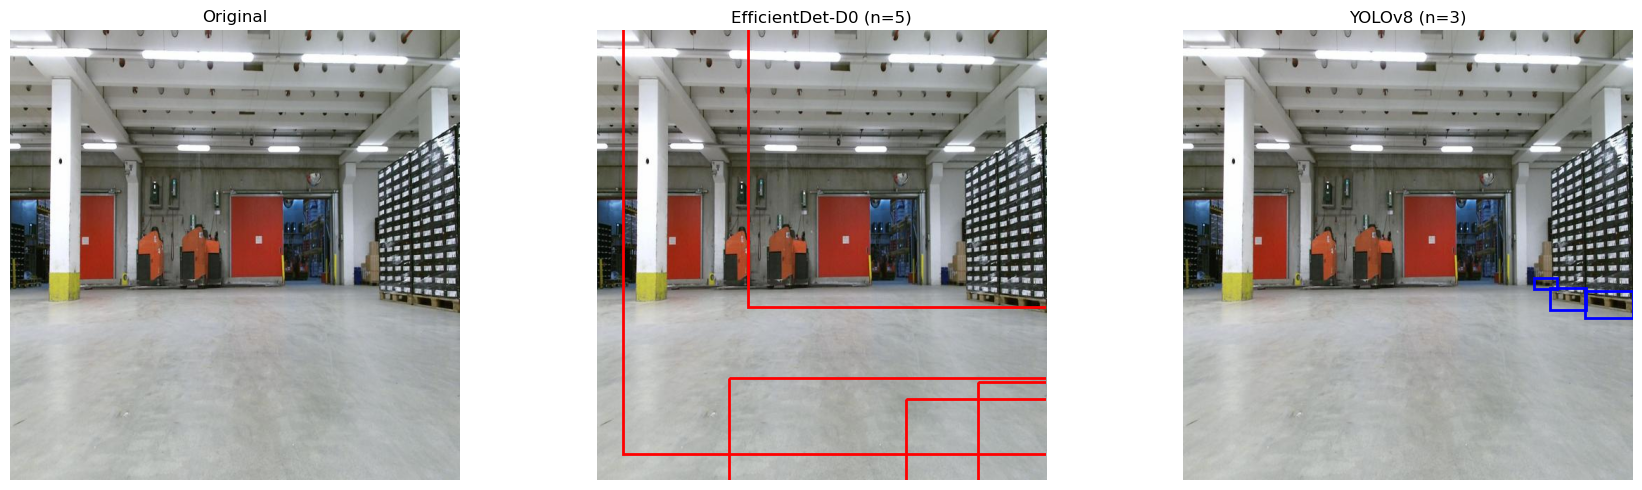

In [11]:
import matplotlib.patches as patches

def plot_boxes(ax, img, boxes, color, label=None):
    ax.imshow(img)
    for (x1, y1, x2, y2) in boxes:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
    ax.axis('off')

def show_detection_example(idx):
    ip = det_val_imgs[idx]
    img_bgr = cv2.imread(ip)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    effdet_pred = det_predict_effdet(ip, top_k=5)          # no conf arg needed
    yolo_pred   = det_predict_yolo(ip,   conf=0.25)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    plot_boxes(axes[1], img, effdet_pred[:, :4], 'r')
    axes[1].set_title(f"EfficientDet-D0 (n={len(effdet_pred)})")
    axes[1].axis("off")

    plot_boxes(axes[2], img, yolo_pred[:, :4], 'b')
    axes[2].set_title(f"YOLOv8 (n={len(yolo_pred)})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

for i in [0, 1, 2]:
    show_detection_example(i)

## Metrics

In [13]:
def seg_metrics_extra(pred, true):
    # pred, true: (N,H,W,1) or (N,H,W) with 0/1
    p = pred[..., 0] if pred.ndim == 4 else pred
    t = true[..., 0] if true.ndim == 4 else true

    p = p.astype(bool)
    t = t.astype(bool)

    tp = np.logical_and(p, t).sum()
    tn = np.logical_and(~p, ~t).sum()
    fp = np.logical_and(p, ~t).sum()
    fn = np.logical_and(~p, t).sum()

    pixel_acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    prec      = tp / (tp + fp + 1e-6)
    rec       = tp / (tp + fn + 1e-6)

    return float(pixel_acc), float(prec), float(rec)

unet_acc, unet_prec, unet_rec = seg_metrics_extra(unet_bin, y_true)
dl_acc,   dl_prec,   dl_rec   = seg_metrics_extra(deeplab_bin, y_true)

In [14]:
def det_simple_stats(predict_fn, imgs):
    num_boxes = []
    scores = []
    for ip in imgs:
        boxes = predict_fn(ip)          # boxes: [N,5] x1,y1,x2,y2,score
        num_boxes.append(len(boxes))
        if len(boxes) > 0:
            scores.extend(boxes[:, 4])
    mean_boxes = float(np.mean(num_boxes))
    mean_score = float(np.mean(scores)) if scores else 0.0
    return mean_boxes, mean_score

# EffDet: we just use your existing helper (top_k inside)
effdet_mean_n, effdet_mean_s = det_simple_stats(
    lambda p: det_predict_effdet(p), det_val_imgs
)

# YOLO: keep conf=0.25
yolo_mean_n, yolo_mean_s = det_simple_stats(
    lambda p: det_predict_yolo(p, conf=0.25), det_val_imgs
)

In [15]:
def model_size_mb_torch(model):
    tmp_path = "tmp_model.pth"
    torch.save(model.state_dict(), tmp_path)
    size = os.path.getsize(tmp_path) / (1024 ** 2)
    os.remove(tmp_path)
    return float(size)

unet_size_mb    = os.path.getsize(UNET_H5) / (1024 ** 2)
deeplab_size_mb = model_size_mb_torch(deeplab_model)
yolo_size_mb    = os.path.getsize(YOLO_PT) / (1024 ** 2)
effdet_size_mb  = os.path.getsize(EFFDET_PTH) / (1024 ** 2)

## Comparison

In [16]:
rows = [
    {
        "Task": "Segmentation",
        "Model": "U-Net (baseline)",
        "IoU": float(unet_iou),
        "Dice": float(unet_dice)
    },
    {
        "Task": "Segmentation",
        "Model": "DeepLabV3+ (variant)",
        "IoU": float(deeplab_iou),
        "Dice": float(deeplab_dice)
    },
    {
        "Task": "Detection",
        "Model": "EfficientDet-D0 (variant)",
        **det_effdet_metrics
    },
    {
        "Task": "Detection",
        "Model": "YOLOv8 (baseline)",
        **det_yolo_metrics
    },
]

df_results = pd.DataFrame(rows)
df_results


,Task,Model,IoU,Dice,mAP@0.5,Latency_ms,FPS
0,Segmentation,U-Net (baseline),0.950954,0.973410,NaN,NaN,NaN
1,Segmentation,DeepLabV3+ (variant),0.921635,0.956187,NaN,NaN,NaN
2,Detection,EfficientDet-D0 (variant),NaN,NaN,0.0,158.556751,6.30689
3,Detection,YOLOv8 (baseline),NaN,NaN,0.0,95.448991,10.47680


In [17]:
for col in ["PixelAcc", "Prec", "Rec", "MeanBoxes", "MeanScore", "Size_MB"]:
    if col not in df_results.columns:
        df_results[col] = np.nan

# U-Net row
m = df_results["Model"] == "U-Net (baseline)"
df_results.loc[m, ["PixelAcc", "Prec", "Rec", "Size_MB"]] = [
    unet_acc, unet_prec, unet_rec, unet_size_mb
]

# DeepLabV3+ row
m = df_results["Model"] == "DeepLabV3+ (variant)"
df_results.loc[m, ["PixelAcc", "Prec", "Rec", "Size_MB"]] = [
    dl_acc, dl_prec, dl_rec, deeplab_size_mb
]

# EfficientDet row
m = df_results["Model"] == "EfficientDet-D0 (variant)"
df_results.loc[m, ["MeanBoxes", "MeanScore", "Size_MB"]] = [
    effdet_mean_n, effdet_mean_s, effdet_size_mb
]

# YOLOv8 row
m = df_results["Model"] == "YOLOv8 (baseline)"
df_results.loc[m, ["MeanBoxes", "MeanScore", "Size_MB"]] = [
    yolo_mean_n, yolo_mean_s, yolo_size_mb
]

df_results

,Task,Model,IoU,Dice,mAP@0.5,Latency_ms,FPS,PixelAcc,Prec,Rec,MeanBoxes,MeanScore,Size_MB
0,Segmentation,U-Net (baseline),0.950954,0.973410,NaN,NaN,NaN,0.988247,0.978395,0.979340,NaN,NaN,209.274101
1,Segmentation,DeepLabV3+ (variant),0.921635,0.956187,NaN,NaN,NaN,0.981473,0.982170,0.950598,NaN,NaN,18.195307
2,Detection,EfficientDet-D0 (variant),NaN,NaN,0.0,158.556751,6.30689,NaN,NaN,NaN,5.000000,0.000586,15.828611
3,Detection,YOLOv8 (baseline),NaN,NaN,0.0,95.448991,10.47680,NaN,NaN,NaN,12.905983,0.567797,42.796068
